# BI-RADS score extraction and classification 

Authors: Elisa Nguyen and Daphne Theodorakopoulos

# Imports & Read Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier as KNN
from xgboost import XGBClassifier

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 1000)
np.set_printoptions(threshold=100000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
train = pd.read_excel('x_train.xlsx')
train = train.dropna()
val = pd.read_excel('x_val.xlsx')
val = val.dropna()
test = pd.read_excel('x_test.xlsx')
test = test.dropna()

#Extract score from conclusions

In [ ]:
def score(row):
  pre = ['birads classificatie', 'birads', 'birads-classificatie', 'birads calcificatie']
  sec = [' rechts', ' links', ' beiderzijds', ' beide','',' ',':',' code','-code', ' categorie', ' echografisch']
  mid = ['','-',' ','- ', ' echografisch ', ' rechts ', ' links ', ' beiderzijds ', ' thans ']
  dic = {0:['0'],1:['1','i', 'een'], 2:['l2','2','ii', 'twee'], 3:['3','iii', 'drie'], 
         4:['4','iv', 'vier'], 5:['5', 'vijf','v'], 6:['6','vi', 'zes']}
  for i in range(6,-1,-1): 
    for p in pre: 
      for s in sec:
        for m in mid:
          for val in dic[i]:
            if (p +s+ m+ val) in row:
              return i

In [ ]:
train['score'] = train['cleaned_text'].apply(score)
val['score'] = val['cleaned_text'].apply(score)
test['score'] = test['cleaned_text'].apply(score)

# Number of reports in each class

<Figure size 576x432 with 0 Axes>

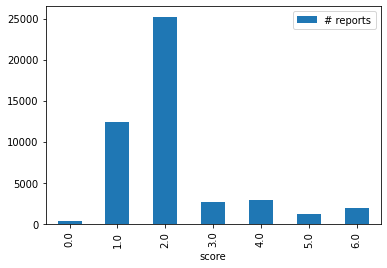

In [ ]:
all_data = train.append(test).append(val)
all_data['# reports'] = all_data['cleaned_text']
fig = plt.figure(figsize=(8,6))
all_data[['# reports', 'score']].groupby('score').count().plot.bar(ylim=0)
plt.savefig('plot3.png', transparent=True)
plt.show()

In [ ]:
print('Number of class 2 in all data:',all_data[all_data['score']==2].shape[0]/all_data.shape[0])

Number of class 2 in all data: 0.5388035137965674


In [ ]:
weights = dict((train.groupby('score').count())['cleaned_text'])
weights

{0.0: 270, 1.0: 8718, 2.0: 17661, 3.0: 1804, 4.0: 2099, 5.0: 806, 6.0: 1393}

# Comparison of different classification algorithms
## Performance measured by accuracy on validation set
## Best models also evaluated on test set

Svc

In [ ]:
svc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',SVC(decision_function_shape='ovo')),
              ])



svc.fit(train['cleaned_text'], train['score'])
val['score_pred'] = svc.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.8297367285282693

svc with class weights

In [ ]:
svc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',SVC(decision_function_shape='ovo', class_weight=weights)),
              ])



svc.fit(train['cleaned_text'], train['score'])
val['score_pred'] = svc.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.8366422097539923

In [ ]:
test['score_pred'] = svc.predict(test['cleaned_text'])
test[test['score']==test['score_pred']].shape[0]/test.shape[0]

0.8331206126356094

linear svc

In [ ]:
lsvc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LinearSVC()),
              ])

lsvc.fit(train['cleaned_text'], train['score'])
val['score_pred'] = lsvc.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.8120414328873543

In [ ]:
test['score_pred'] = lsvc.predict(test['cleaned_text'])
test[test['score']==test['score_pred']].shape[0]/test.shape[0]

0.8103594979791534

linear svc using class weights

In [ ]:
lsvc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LinearSVC(class_weight=weights)),
              ])



lsvc.fit(train['cleaned_text'], train['score'])
val['score_pred'] = lsvc.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7738454898575744

logistic regression


In [ ]:
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

lr.fit(train['cleaned_text'], train['score'])
val['score_pred'] = lr.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8109624514458351

In [ ]:
test['score_pred'] = lr.predict(test['cleaned_text'])
test[test['score']==test['score_pred']].shape[0]/test.shape[0]

0.8144011912359073

logistic regression with cross validation

In [ ]:
lr_cv = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',LogisticRegressionCV()),
              ])



lr_cv.fit(train['cleaned_text'], train['score'])
val['score_pred'] = lr_cv.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.8172205438066465

In [ ]:
test['score_pred'] = lr_cv.predict(test['cleaned_text'])
test[test['score']==test['score_pred']].shape[0]/test.shape[0]

0.8164220378642842

Naive Bayes

In [ ]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(class_prior=list(weights.values())/sum(weights.values()))),
              ])



nb.fit(train['cleaned_text'], train['score'])
val['score_pred'] = nb.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.6700474751834269

Random Forest using 200 estimators

In [ ]:
rf = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(n_estimators=200,random_state=0)),
              ])



rf.fit(train['cleaned_text'], train['score'])
val['score_pred'] = rf.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.7734138972809668

Random Forest using 80 estimators

In [ ]:
rf = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(n_estimators=80,random_state=0)),
              ])



rf.fit(train['cleaned_text'], train['score'])
val['score_pred'] = rf.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.7693137678031938

KNN

In [ ]:
knn = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', KNN()),
              ])



knn.fit(train['cleaned_text'], train['score'])
val['score_pred'] = knn.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.6959430297798878

Gradient Boosted Trees

In [ ]:
xgboost = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',XGBClassifier()),
              ])



xgboost.fit(train['cleaned_text'], train['score'])
val['score_pred'] = xgboost.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.779887785930082

Ridge Classifier

In [ ]:
ridge = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',RidgeClassifier()),
              ])



ridge.fit(train['cleaned_text'], train['score'])
val['score_pred'] = ridge.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.7962883038411739

Ridge Classifier with cross validation

In [ ]:
rc_cv = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',RidgeClassifierCV()),
              ])



rc_cv.fit(train['cleaned_text'], train['score'])
val['score_pred'] = rc_cv.predict(val['cleaned_text'])
val[val['score']==val['score_pred']].shape[0]/val.shape[0]

0.7965041001294778

In [ ]:
test['score_pred'] = rc_cv.predict(test['cleaned_text'])
test[test['score']==test['score_pred']].shape[0]/test.shape[0]

0.7945118059987237